<a href="https://colab.research.google.com/github/greentfrapp/lucent/blob/master/notebooks/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<img src="https://raw.githubusercontent.com/greentfrapp/lucent/master/images/lucent_header.jpg" width="600"></img>

# Lucent Tutorial

A Colab notebook following the spirit of Lucid's notebooks.



## Install, Import, Load Model

In [2]:
!pip install --quiet git+https://github.com/greentfrapp/lucent.git

     |████████████████████████████████| 163kB 6.9MB/s 


In [0]:
import torch

from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import inceptionv1

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = inceptionv1(pretrained=True)
_ = model.to(device).eval()

Similar to [Lucid](https://github.com/tensorflow/lucid/), this tutorial will be focused on the same InceptionV1 model, also known as GoogLeNet.

Check out the original GoogLeNet paper [here](https://research.google.com/pubs/archive/43022.pdf).

[Distill](https://distill.pub) also has a fascinating [article](https://distill.pub/2017/feature-visualization/) on this topic that includes visualizations of all the InceptionV1 neurons.


## Visualize!

`render_vis` has a few nice defaults so we can get started quickly!

100%|██████████| 512/512 [00:29<00:00, 17.27it/s]



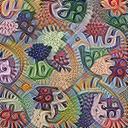

In [5]:
_ = render.render_vis(model, "mixed4a:476", show_inline=True)

## Fiddling with the Knobs

Just like Lucid, Lucent splits visualizations into *objectives*, *parameterizations* and *transforms*. To quote from Lucid's tutorial:

* **Objectives** -- What do you want the model to visualize?
* **Parameterizations** -- How do you describe the image?
* **Transforms** -- What transformations do you want your visualization to be robust to?

### Objectives

What loss function do we want to minimize?

Or from another point of view, what part of the model do we want to understand?

In essence, we are trying to generate an image that causes a particular neuron or filter to activate strongly. The objective allows us to select a specific neuron, channel or a mix!

100%|██████████| 512/512 [00:29<00:00, 17.36it/s]



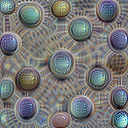

In [6]:
# The default is optimizing for a channel/filter
obj = objectives.channel("mixed4a", 465)
_ = render.render_vis(model, obj, show_inline=True)

100%|██████████| 512/512 [00:30<00:00, 17.06it/s]



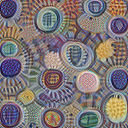

In [7]:
# Just like in Lucid, we can sum objectives
# Here we sum the previous two objectives and get a mix of the two images
channel = lambda n: objectives.channel("mixed4a", n)
obj = channel(476) + channel(465)
_ = render.render_vis(model, obj, show_inline=True)

100%|██████████| 512/512 [00:34<00:00, 14.74it/s]



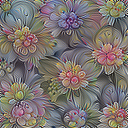

In [8]:
# Here's a favorite!
obj = "mixed4d_3x3_bottleneck_pre_relu_conv:139"
_ = render.render_vis(model, obj, show_inline=True)

### Parameterizations

For an initial attempt at feature visualization, we might do gradient descent in the pixel space of a randomly initialized image. Unfortunately, this often creates images comprising high frequency noise, similar to [adversarial images](https://arxiv.org/abs/1312.6199).

Instead, the use of alternative parameterizations can produce more visually intuitive results, by operating in the frequency domain or using compositional pattern producing networks.

Recomended reading: Distill's Feature Visualization article, specifically the section on [Preconditioning and Parameterization](https://distill.pub/2017/feature-visualization/#preconditioning)

100%|██████████| 512/512 [00:30<00:00, 16.89it/s]



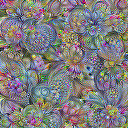

In [9]:
# A visualization with gradient descent in pixel space
# Notice the high frequency components similar to adversarial images

param_f = lambda: param.image(128, fft=False, decorrelate=False)
# We set transforms=[] to denote no transforms
_ = render.render_vis(model, obj, param_f, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:30<00:00, 16.64it/s]



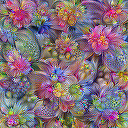

In [10]:
# A visualization with gradient descent in Fourier basis

param_f = lambda: param.image(128, fft=True, decorrelate=False)
_ = render.render_vis(model, obj, param_f, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:30<00:00, 16.68it/s]



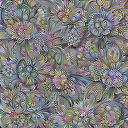

In [11]:
# A visualization with channel decorrelation

param_f = lambda: param.image(128, fft=False, decorrelate=True)
_ = render.render_vis(model, obj, param_f, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:30<00:00, 16.55it/s]



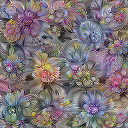

In [12]:
# A visualization with gradient descent in Fourier basis + channel decorrelation
# This is the default parameterization without transforms (see below)

param_f = lambda: param.image(128, fft=True, decorrelate=True)
_ = render.render_vis(model, obj, param_f, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:34<00:00, 14.84it/s]



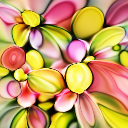

In [13]:
# A visualization with CPPN parameterization

cppn_param_f = lambda: param.cppn(128)
# We initialize an optimizer with lower learning rate for CPPN
cppn_opt = lambda params: torch.optim.Adam(params, 5e-3)
_ = render.render_vis(model, obj, cppn_param_f, cppn_opt, transforms=[], show_inline=True)

### Transformations

Another way to reduce high-frequency components in the visualization is by imposing constraints in the form of transformation robustness.

Read more about this in [The Enemy of Feature Visualization](https://distill.pub/2017/feature-visualization/#enemy-of-feature-vis) from Distill's Feature Visualization article.

100%|██████████| 512/512 [00:31<00:00, 16.24it/s]



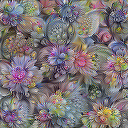

In [14]:
# No transformations, similar to our example earlier

_ = render.render_vis(model, obj, transforms=[], show_inline=True)

100%|██████████| 512/512 [00:32<00:00, 15.61it/s]



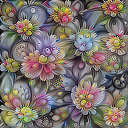

In [15]:
# Adding jitter, notice that the visualization is much less noisy!

jitter_only = [transform.jitter(8)]

_ = render.render_vis(model, obj, transforms=jitter_only, show_inline=True)

100%|██████████| 512/512 [00:36<00:00, 14.17it/s]



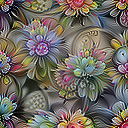

In [16]:
# Adding a whole suite of transforms!

all_transforms = [
    transform.pad(16),
    transform.jitter(8),
    transform.random_scale([n/100. for n in range(80, 120)]),
    transform.random_rotate(list(range(-10,10)) + list(range(-5,5)) + 10*list(range(-2,2))),
    transform.jitter(2),
]

_ = render.render_vis(model, obj, transforms=all_transforms, show_inline=True)

100%|██████████| 512/512 [00:37<00:00, 13.77it/s]



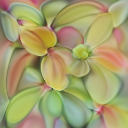

In [17]:
# Adding jitter with CPPN

_ = render.render_vis(model, obj, cppn_param_f, cppn_opt, transforms=jitter_only, show_inline=True)

100%|██████████| 512/512 [00:40<00:00, 12.60it/s]



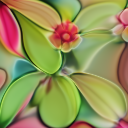

In [18]:
# Adding a suite of transforms with CPPN

_ = render.render_vis(model, obj, cppn_param_f, cppn_opt, transforms=all_transforms, show_inline=True)

## Conclusion

And that's it for now!

Credits to the folks at [Lucid](https://github.com/tensorflow/lucid) for doing such a great job at creating the original library for Tensorflow!

Also, a big thanks to [ProGamerGov](https://github.com/ProGamerGov) for converting the original Tensorflow InceptionV1 model to PyTorch!

If you are interested, do check out the `#proj-lucid` channel on the Distill slack ([join link](http://slack.distill.pub))!